## Data Preparation

In [3]:
import numpy as np
from tqdm import tqdm
import json
from collections import Counter
from collections import defaultdict
from scipy import sparse
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
dataLines = []
with open("../../Data/reviews.txt") as file:
    for line in tqdm(file):
        dataLines.append(line)

print("Number of lines: ", len(dataLines))

4607047it [00:08, 536443.01it/s]

Number of lines:  4607047


In [6]:
# dictionary 
n_samples = 100000
wordDict = defaultdict(int)
for line in tqdm(dataLines[:n_samples]):
    line = line.split()
    for word in line:
        wordDict[word] += 1

smallData = []
for sent in tqdm(dataLines[:n_samples]):
    sen = sent.split()
    x = []
    for w in sen:
        if wordDict[w] > 8:
            x.append(w)
    smallData.append(' '.join(x))


100%|██████████| 100000/100000 [00:03<00:00, 26934.60it/s]


In [8]:

import pickle
with open("../../Data/smallData.pkl", "wb") as fp:
    pickle.dump(smallData, fp)


In [10]:
# unpickle the data
import pickle 

with open("../../Data/smallData.pkl","rb") as fp:
    smallData = pickle.load(fp)


# SVD

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(smallData)
features_names = vectorizer.get_feature_names_out()


In [12]:
# save features_names
with open("../../Data/features_names_small.txt", "w") as fp:
    fp.write("\n".join(features_names))

In [13]:
print(X.shape)

(100000, 27648)


In [14]:
# create co-occurence matrix
co_occurence_matrix = X.T.dot(X)
# set the diagonal to zero
co_occurence_matrix.setdiag(0)
print(co_occurence_matrix.shape)


(27648, 27648)


In [15]:
from scipy import sparse
sparse.save_npz("../../Data/co_occurenceMatrix_small.npz", co_occurence_matrix)


# Apply SVD to the data matrix 
### Using truncated SVD to reduce the dimensionality of the data matrix

In [16]:
# load the co-occurence matrix
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
# co_occurence_matrix = sparse.load_npz("../../Data/co_occurenceMatrix_small.npz")

Svd = TruncatedSVD(n_components=400, n_iter=5, random_state=42)
svd_matrix = Svd.fit_transform(co_occurence_matrix)


In [17]:
print("SVD matrix shape: ", svd_matrix.shape)
print("Sum of explained variance: ", np.sum(Svd.explained_variance_ratio_))
print("Eigen values: ", Svd.singular_values_)


SVD matrix shape:  (27648, 400)
Sum of explained variance:  0.999996926792734
Eigen values:  [2.72823378e+07 1.07495385e+07 3.42886723e+06 2.61203931e+06
 1.87204872e+06 1.38502504e+06 9.38118243e+05 8.39284203e+05
 6.36280160e+05 4.95726133e+05 3.05024924e+05 2.82642175e+05
 2.72420563e+05 2.62694778e+05 2.55965978e+05 2.34776887e+05
 1.98651784e+05 1.89990939e+05 1.72916287e+05 1.44767126e+05
 1.37537346e+05 1.22905048e+05 1.17312926e+05 1.13337310e+05
 1.04555118e+05 1.01630148e+05 8.93479305e+04 8.38107010e+04
 8.33106162e+04 8.08567710e+04 7.46806597e+04 6.82019762e+04
 6.43487771e+04 5.96585723e+04 5.90182347e+04 5.81996998e+04
 5.69549428e+04 5.54435340e+04 4.99585740e+04 4.79749704e+04
 4.68895542e+04 4.26635441e+04 4.11406642e+04 4.06164561e+04
 3.96431580e+04 3.89541109e+04 3.84754369e+04 3.71165341e+04
 3.51778187e+04 3.43229776e+04 3.42622181e+04 3.32484650e+04
 3.26257506e+04 3.13643013e+04 2.93732968e+04 2.81151318e+04
 2.77203888e+04 2.66919923e+04 2.61340689e+04 2.48872

In [18]:
np.savez_compressed('../../Data/SVD_matrix_small.npz', a=svd_matrix)


In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance

feature_list = []
with open("../../Data/features_names_small.txt") as file:
    for line in file:
        feature_list.append(line.strip('\n'))

# load the SVD matrix
svd_matrix = np.load('../../Data/SVD_matrix_small.npz')['a']

def plot_top_10_words(word,token_list,svd_matrix):
    def tsne_plot(results):
        words = [x[0] for x in results]
        tokens = [x[1] for x in results]
        words = np.array(words)
        tokens = np.array(tokens)

        tsne_model = TSNE(init='pca',perplexity=9,random_state=42)
        res_embeds = tsne_model.fit_transform(tokens)

        x_axis = res_embeds[:,0]
        y_axis = res_embeds[:,1]

        plt.figure(figsize=(5,5))
        for i in range(len(x_axis)):
            plt.scatter(x_axis[i],y_axis[i])
            plt.annotate(words[i],xy=(x_axis[i],y_axis[i]),xytext=(5,2),textcoords='offset points',ha='right',va='bottom')
        plt.savefig('./Results/'+word+'.png')

    word_index = token_list.index(word)
    word_vector = svd_matrix[word_index]
    res = {}
    for i,embed in tqdm(enumerate(svd_matrix)):
        if i!=word_index:
            res[i] = [1- distance.cosine(svd_matrix[i],word_vector),svd_matrix[i]]

    results = sorted(res.items(), key=lambda x: x[1][0], reverse=True)[:10]
    results = [(token_list[x[0]],x[1][1]) for x in results]

    print('Word: ', word)
    # print(results)
    print('Top 10 similar words: ', [x[0] for x in results])
    tsne_plot(results)



27648it [00:01, 22567.25it/s]


Word:  ship
Top 10 similar words:  ['deck', 'ships', 'aboard', 'crew', 'passengers', 'port', 'officers', 'sinking', 'chief', 'combat']


27648it [00:08, 3362.41it/s]


Word:  begin
Top 10 similar words:  ['bring', 'become', 'reach', 'come', 'take', 'turn', 'develop', 'comes', 'offer', 'leave']


27648it [00:01, 24958.11it/s]


Word:  well
Top 10 similar words:  ['especially', 'almost', 'long', 'far', 'different', 'few', 'bit', 'quite', 'though', 'star']


27648it [00:00, 28051.32it/s]


Word:  great
Top 10 similar words:  ['absolutely', 'amazing', 'definitely', 'stars', 'entertaining', 'acting', 'good', 'totally', 'times', 'very']


27648it [00:01, 21390.40it/s]


Word:  my
Top 10 similar words:  ['watching', 'heard', 'am', 'maybe', 'wish', 'really', 'thought', 'guess', 'me', 'sure']


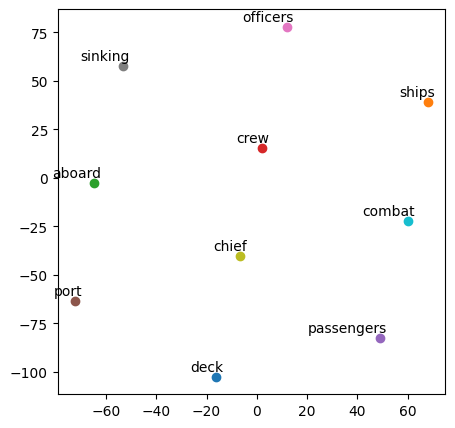

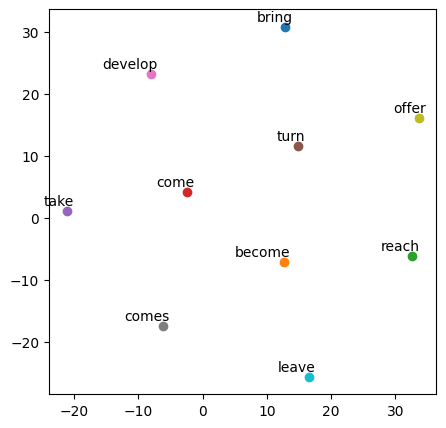

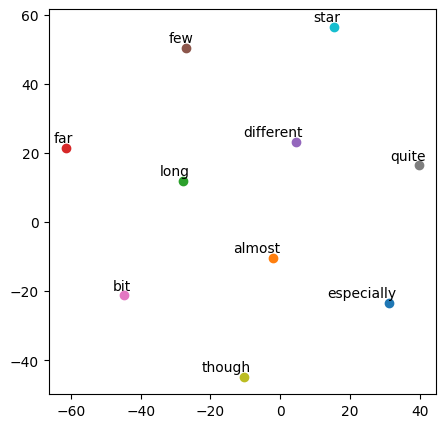

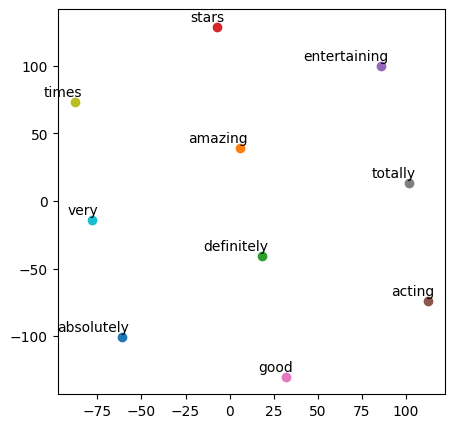

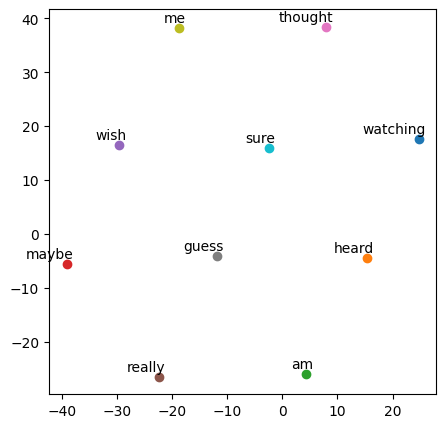

In [20]:
# take five different type of words and plot the top 10 similar words in the same graph
words = ['ship','begin','well','great','my']
for word in words:
    plot_top_10_words(word,feature_list,svd_matrix)

27648it [00:04, 6057.07it/s]


Word:  titanic
Top 10 similar words:  ['sinking', 'sank', 'iceberg', 'californian', 'sunk', 'ship', 'illustrator', '1912', 'composite', 'deck']


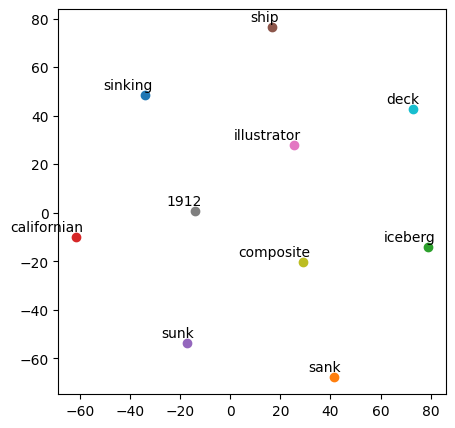

In [21]:
plot_top_10_words("titanic", feature_list, svd_matrix)
